In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('../Train.csv')
data.drop(index = [1815], inplace=True) # removed weird row
data.drop(['ADM4_PCODE','ward'], axis=1, inplace=True) # removed non-predictors
# move target to first column
target = data.pop('target')
data.insert(0, 'target', target)
data.head(3)

,target,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,...,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL
0,16.773757,1674.45058,5888.20750,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,...,0.019968,0.002848,0.007537,0.000000,0.012928,0,0,-29.682270,24.734743,0.292039
1,21.496661,1736.99230,6735.33812,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,...,0.018946,0.014566,0.057127,0.019092,0.004131,0,0,-29.119311,24.757737,3.207775
2,10.931425,2403.57591,7273.04995,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,...,0.083010,0.057560,0.010358,0.001421,0.040881,0,0,-29.142276,25.094093,0.000000


In [3]:
var_desc = pd.read_csv('../variable_descriptions.csv')
pd.set_option('display.max_colwidth', 200) # So that we can see the full descriptions
var_desc.head(3)

,Column,Description,Unnamed: 2,Unnamed: 3
0,dw_00,Percentage of dwellings of type: House or brick/concrete block structure on a separate stand or yard or on a farm,NaN,NaN
1,dw_01,Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials,NaN,NaN
2,dw_02,Percentage of dwellings of type: Flat or apartment in a block of flats,NaN,NaN


### A) General summary from EDA:
#### 1) Relatively clean data with no missing values and many strong predictors
#### 2) Makes sense to treat predictors based on the category of demographical information they belong to
##### a) target = population + dwelling + school + tv + car + landline + language + race + water + gis
#### 3) Predictors within each category are complementary percentages that add up to 1, and hence would likely to have high levels of intra-correlation and should be simplified whenever possible
#### 4) Redundant predictors to drop in all cases: dw_12 , dw_13, stv_01, car_01, lln_00, lan_13, pw_07, pw_08
#### 5) Engineered features to test: dw_00_02, dw_03_04, dw_07_08, lan_isafrican, race_dom5, pg_00_cat2, pw_02_06, pw_dom3
#### 6) Many predictors require log-transform:
##### ['dw_00','dw_01','dw_02','dw_03','dw_04','dw_05','dw_06','dw_07','dw_08','dw_09','dw_10','dw_11','dw_00_02','dw_03_04','dw_07_08','psa_03','psa_04','stv_00','car_00','lln_00','lan_00','lan_01','lan_02','lan_03','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14','lan_isafrican','pg_00','pg_01','pg_02','pg_03','pg_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']
#### 7) Normalize scaling of all predictors prior to training

### B) For each category:
#### Dwelling:
##### 1) test a model where a) dwelling = dw_00_02 + dw_03_04 + dw_05 + dw_06 + dw_07_08 + dw_09 + dw_10 + dw_11 and b) dwelling = dw_00
##### 2) dw_00-11, dw_00_02, dw_03_04, dw_07_08, if used, should be log-transformed
##### 3) polynomial coefficients potentially better fit for dw_01, dw_03, dw_04, dw_07, dw_08, dw_03_04, dw_07_08
#### Schooling: 
##### 1) test a model where school = psa_00
##### 2) psa_03 and psa_04, if used, should be log-transformed
#### TV/car/landline access:
##### 1) all are binary categories
##### 2) stv_00, car_00, lln_00, if used, should be log-transformed
#### Language:
##### 1) test a model where a) language = lan_08 and b) language = is_lan_african
##### 2) lan_00-03, lan_05-12, lan_14, lan_isafrican if used, should be log-transformed
##### 3) polynomial coefficients potentially better fit for lan_00, lan_01, lan_04, lan_isafrican
#### Race:
##### 1) test a model where a) race = race_dom5, and b) race = pg_00_cat2 + pg_01 + pg_02 + pg_03 + pg_04
##### 2) pg_00-04, if used, should be log-transformed
#### Water access:
##### 1) test a model where a) water = pw_00 + pw_01 + pw_02_06, and b) water = pw_dom3
##### 2) pw_02-06, if used, should be log-transformed

### C) Modeling
#### - Scoring = RMSE --> 'neg_root_mean_squared_error' (minimize)
#### - Potential base models: linreg/polyreg + ridge/lasso/backward stepwise, regression forest, neural net
#### - Potential optimization/tuning methods: K-fold, bagged ensembles, boosting (AdaBoost, XGBoost, LGBM), optimize tuning parameters like tree depth, neural net depth/architecture/optimizer/learning rate

# I) Building final dataset for training

In [4]:
# removing redundant predictors
data.drop(['dw_12','dw_13','stv_01','car_01','lln_01','lan_13','pw_07','pw_08'], axis=1, inplace=True)

In [5]:
# adding engineered features
data['dw_00_02'] = data[['dw_00','dw_01','dw_02']].sum(axis=1)
data['dw_03_04'] = data[['dw_03','dw_04',]].sum(axis=1)
data['dw_07_08'] = data[['dw_07','dw_08']].sum(axis=1)
data['lan_isafrican'] = data[['lan_00','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_09','lan_10','lan_11']].sum(axis=1)
data['pg_00_cat2'] = (data.pg_00>0.9).astype(int)
data['pw_02_06'] = data[['pw_02','pw_03','pw_04','pw_05','pw_06']].sum(axis=1)
data = pd.concat([data, pd.get_dummies(data[['pg_00','pg_01','pg_02','pg_03','pg_04']].idxmax(axis=1).astype('category'), prefix='dom')], axis=1)
data = pd.concat([data, pd.get_dummies(data[['pw_00','pw_01','pw_02_06']].idxmax(axis=1).astype('category'), prefix='dom')], axis=1)

In [6]:
# log-transforming relevant predictors
log_transform_needed = ['dw_00','dw_01','dw_02','dw_03','dw_04','dw_05','dw_06','dw_07','dw_08','dw_09','dw_10','dw_11','dw_00_02','dw_03_04','dw_07_08','psa_03','psa_04','stv_00','car_00','lln_00','lan_00','lan_01','lan_02','lan_03','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14','lan_isafrican','pg_00','pg_01','pg_02','pg_03','pg_04','pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']
data[log_transform_needed] = data[log_transform_needed]+0.0001
data[log_transform_needed] = np.log(data[log_transform_needed])

In [8]:
data.head(3)

,target,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,...,lan_isafrican,pg_00_cat2,pw_02_06,dom_pg_00,dom_pg_01,dom_pg_02,dom_pg_03,dom_pw_00,dom_pw_01,dom_pw_02_06
0,16.773757,1674.45058,5888.20750,-0.068342,-6.963562,-5.186750,-7.160772,-9.210340,-6.520896,-5.141335,...,-0.025741,0,0.043281,0,1,0,0,1,0,0
1,21.496661,1736.99230,6735.33812,-0.360912,-6.605512,-5.403209,-9.210340,-6.031712,-6.555033,-4.869827,...,-0.041333,0,0.113862,1,0,0,0,0,1,0
2,10.931425,2403.57591,7273.04995,-0.209925,-5.378009,-4.711545,-5.500117,-4.849205,-6.853223,-4.992851,...,-0.024053,0,0.193231,1,0,0,0,0,1,0


In [9]:
# customize model inputs here
Y = data.target

# Linear Model #1: all original predictors
population_1 = ['total_households','total_individuals']
dwelling_1 = ['dw_00','dw_01','dw_02','dw_03','dw_04','dw_05','dw_06','dw_07','dw_08','dw_09','dw_10','dw_11']
school_1 = ['psa_00','psa_01','psa_02','psa_03','psa_04']
tv_1 = ['stv_00']
car_1 = ['car_00']
landline_1 = ['lln_00']
language_1 = ['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']
race_1 = ['pg_00','pg_01','pg_02','pg_03','pg_04']
water_1 = ['pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06']
gis_1 = ['lat','lon','NL']
X_1 = data[population_1+dwelling_1+school_1+tv_1+car_1+landline_1+language_1+race_1+water_1+gis_1]

# Linear Model #2: all original predictors + all engineered
population_2 = ['total_households','total_individuals']
dwelling_2 = ['dw_00','dw_01','dw_02','dw_03','dw_04','dw_05','dw_06','dw_07','dw_08','dw_09','dw_10','dw_11','dw_00_02','dw_03_04','dw_07_08']
school_2 = ['psa_00','psa_01','psa_02','psa_03','psa_04']
tv_2 = ['stv_00']
car_2 = ['car_00']
landline_2 = ['lln_00']
language_2 = ['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14','lan_isafrican']
race_2 = ['pg_00','pg_01','pg_02','pg_03','pg_04','pg_00_cat2','dom_pg_00','dom_pg_01','dom_pg_02','dom_pg_03']
water_2 = ['pw_00','pw_01','pw_02','pw_03','pw_04','pw_05','pw_06','pw_02_06','dom_pw_00','dom_pw_01','dom_pw_02_06']
gis_2 = ['lat','lon','NL']
X_2 = data[population_2+dwelling_2+school_2+tv_2+car_2+landline_2+language_2+race_2+water_2+gis_2]


# Linear Model #3: reduced for dwelling, race, and water
population_3 = ['total_households','total_individuals']
dwelling_3 = ['dw_00_02','dw_03_04','dw_05','dw_06','dw_07_08','dw_09','dw_10','dw_11']
school_3 = ['psa_00','psa_01','psa_02','psa_03','psa_04']
tv_3 = ['stv_00']
car_3 = ['car_00']
landline_3 = ['lln_00']
language_3 = ['lan_00','lan_01','lan_02','lan_03','lan_04','lan_05','lan_06','lan_07','lan_08','lan_09','lan_10','lan_11','lan_12','lan_14']
race_3 = ['pg_00_cat2','pg_01','pg_02','pg_03','pg_04']
water_3 = ['pw_00','pw_01','pw_02_06']
gis_3 = ['lat','lon','NL']
X_3 = data[population_3+dwelling_3+school_3+tv_3+car_3+landline_3+language_3+race_3+water_3+gis_3]

# Linear Model #4: reduced for dwelling, race, and water + single predictor for the rest
population_4 = ['total_households','total_individuals']
dwelling_4 = ['dw_00_02','dw_03_04','dw_05','dw_06','dw_07_08','dw_09','dw_10','dw_11']
school_4 = ['psa_00']
tv_4 = ['stv_00']
car_4 = ['car_00']
landline_4 = ['lln_00']
language_4 = ['lan_08']
race_4 = ['dom_pg_00','dom_pg_01','dom_pg_02','dom_pg_03']
water_4 = ['dom_pw_00','dom_pw_01','dom_pw_02_06']
gis_4 = ['lat','lon','NL']
X_4 = data[population_4+dwelling_4+school_4+tv_4+car_4+landline_4+language_4+race_4+water_4+gis_4]

# Linear Model #5-6: single predictor for all
population_5 = ['total_households','total_individuals']
dwelling_5 = ['dw_00']
school_5 = ['psa_00']
tv_5 = ['stv_00']
car_5 = ['car_00']
landline_5 = ['lln_00']
language_5_a = ['lan_08']
language_5_b = ['lan_08']
race_5 = ['dom_pg_00','dom_pg_01','dom_pg_02','dom_pg_03']
water_5 = ['dom_pw_00','dom_pw_01','dom_pw_02_06']
gis_5 = ['lat','lon','NL']
X_5 = data[population_5+dwelling_5+school_5+tv_5+car_5+landline_5+language_5_a+race_5+water_5+gis_5]
X_6 = data[population_5+dwelling_5+school_5+tv_5+car_5+landline_5+language_5_b+race_5+water_5+gis_5]

X = [X_1, X_2, X_3, X_4, X_5, X_6]


# II) Regularization

In [10]:
# Linear regression

linear_models = {}
linear_rfes = {}
linear_ridges = {}
linear_lassos = {}

for i, x in enumerate(X):
    print([i+1])
    # fit linear model
    linear_models[i] = LinearRegression()
    linear_models[i].fit(X=x, y=Y)
    # backwards step-wise
    linear_rfes[i] = RFECV(estimator=linear_models[i], cv=10, scoring="neg_root_mean_squared_error")
    linear_rfes[i].fit(X=x, y=Y)
    print(x.columns[linear_rfes[i].support_])
    # ridge
    alphas = [0.001, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0]
    linear_ridges[i] = RidgeCV(alphas=alphas, scoring="neg_root_mean_squared_error", cv=10, normalize=True)
    linear_ridges[i].fit(X=x, y=Y)
    print(linear_ridges[i].alpha_)
    # lasso
    linear_lassos[i] = LassoCV(n_alphas=100, cv=10, normalize=True)
    linear_lassos[i].fit(X=x, y=Y)
    print(linear_lassos[i].alpha_)

[1]
Index(['dw_00', 'dw_02', 'psa_00', 'psa_01', 'psa_02', 'psa_04', 'car_00',
       'lln_00', 'lan_00', 'lan_03', 'lan_04', 'lan_07', 'lan_09', 'lan_10',
       'pg_00', 'pg_01', 'pg_02', 'pw_00', 'lon'],
      dtype='object')
0.025
0.0015143793832737451
[2]
Index(['dw_00', 'dw_02', 'dw_04', 'dw_09', 'dw_00_02', 'psa_00', 'psa_01',
       'psa_02', 'psa_04', 'stv_00', 'car_00', 'lln_00', 'lan_00', 'lan_01',
       'lan_03', 'lan_04', 'lan_07', 'lan_09', 'lan_10', 'lan_12',
       'lan_isafrican', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_00_cat2',
       'dom_pg_00', 'dom_pg_02', 'dom_pg_03', 'pw_00', 'pw_01', 'pw_02_06',
       'dom_pw_00', 'dom_pw_02_06', 'lon'],
      dtype='object')
0.05
0.0018669976849473233
[3]
Index(['dw_00_02', 'dw_06', 'dw_09', 'psa_00', 'psa_01', 'psa_02', 'psa_04',
       'stv_00', 'car_00', 'lln_00', 'lan_00', 'lan_01', 'lan_03', 'lan_04',
       'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_12', 'lan_14',
       'pg_00_cat2', 'pg_01', 'pg_02', 'pg

In [ ]:
# Polynomial regression


# III) Train/Test

In [17]:
# The quality of an RMSE score relates to the label's distribution. RMSE/std should at least be <1
# Top 20 of Zindi is <3.5
target.describe()

count    2821.000000
mean       24.516242
std        10.285861
min         1.671886
25%        16.758903
50%        24.157369
75%        32.227600
max        55.528423
Name: target, dtype: float64

In [18]:
linear_results = {}
rf_results = {}
for i in range(len(X)):
    pipeline_linear = Pipeline([('scaler', StandardScaler()),('model', LinearRegression())])
    pipeline_rf = Pipeline([('scaler', StandardScaler()),('model', RandomForestRegressor())])
    linear_results['cv_linear_{0}'.format(i+1)] = cross_val_score(estimator=pipeline_linear, X=X[i], y=Y, scoring='neg_mean_squared_error', cv=10)
    linear_results['cv_linear_rfe_{0}'.format(i+1)] = cross_val_score(estimator=pipeline_linear, X=X[i][X[i].columns[linear_rfes[i].support_]], y=Y, scoring="neg_mean_squared_error", cv=10)
    linear_results['cv_linear_ridge_{0}'.format(i+1)] = cross_val_score(estimator=Ridge(alpha=linear_ridges[i].alpha_), X=X[i], y=Y, scoring="neg_root_mean_squared_error", cv=10)
    linear_results['cv_linear_lasso_{0}'.format(i+1)] = cross_val_score(estimator=Lasso(alpha=linear_lassos[i].alpha_), X=X[i], y=Y, scoring="neg_root_mean_squared_error", cv=10)
    rf_results['cv_rf_{0}'.format(i+1)] = cross_val_score(pipeline_rf, X=X[i], y=Y, scoring='neg_root_mean_squared_error', cv=10)
    print([i+1])
    print('Linear:', -linear_results['cv_linear_{0}'.format(i+1)].mean())
    print('Linear RFE:', -linear_results['cv_linear_rfe_{0}'.format(i+1)].mean())
    print('Linear Ridge:', -linear_results['cv_linear_ridge_{0}'.format(i+1)].mean())
    print('Linear Lasso:', -linear_results['cv_linear_lasso_{0}'.format(i+1)].mean())
    print('Random Forest:', -rf_results['cv_rf_{0}'.format(i+1)].mean())

[1]
Linear: 16.785672688649964
Linear RFE: 15.49575181429156
Linear Ridge: 4.061346055473148
Linear Lasso: 4.061456563887658
Random Forest: 3.950808258307241
[2]
Linear: 16.92226459550187
Linear RFE: 15.59475684272725
Linear Ridge: 4.078761365080187
Linear Lasso: 4.0667715679028795
Random Forest: 4.009973008915052
[3]
Linear: 16.32937331629111
Linear RFE: 15.468053062753205
Linear Ridge: 4.002321292244011
Linear Lasso: 4.003759789630182
Random Forest: 3.9887136434650863
[4]
Linear: 20.536766901529234
Linear RFE: 20.114680208548975
Linear Ridge: 4.493270325361883
Linear Lasso: 4.483317704041157
Random Forest: 4.162012443084139
[5]
Linear: 21.351430105341556
Linear RFE: 20.820670158402514
Linear Ridge: 4.571865032758621
Linear Lasso: 4.561846076555971
Random Forest: 4.166834304570374
[6]
Linear: 21.351430105341556
Linear RFE: 20.820670158402514
Linear Ridge: 4.571865032758621
Linear Lasso: 4.561846076555971
Random Forest: 4.149152473731003


# X_1

      actual  predicted  residual
0  16.773757  16.244024  0.529732
1  21.496661  23.499168 -2.002507
2  10.931425  13.085330 -2.153905
3  23.119257  22.040930  1.078327
4  13.652252  14.311249 -0.658997
R squared = 0.867


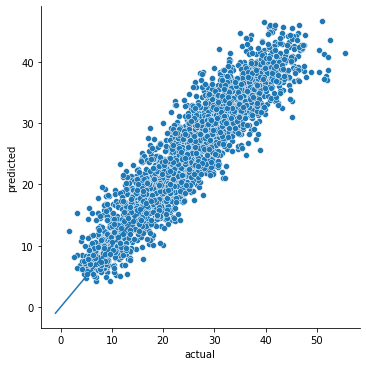

In [22]:
predX_1 = linear_models[0].predict(X_1)
pred1 = pd.DataFrame({'actual':Y,'predicted':predX_1})
pred1['residual'] = pred1.actual - pred1.predicted
print(pred1.head(5))

sns.relplot(x=pred1.actual, y=pred1.predicted)
import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100))

print('R squared =', round(np.corrcoef(pred1.actual, y=pred1.predicted)[0,1]**2,3))

# X_2

      actual  predicted  residual
0  16.773757  16.256556  0.517201
1  21.496661  23.696215 -2.199553
2  10.931425  13.473519 -2.542094
3  23.119257  23.169995 -0.050738
4  13.652252  14.790451 -1.138199
R squared = 0.87


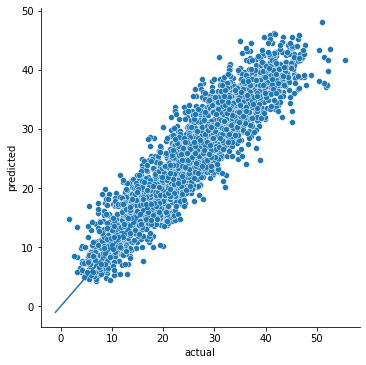

In [23]:
predX_2 = linear_models[1].predict(X_2)
pred2 = pd.DataFrame({'actual':Y,'predicted':predX_2})
pred2['residual'] = pred2.actual - pred2.predicted
print(pred2.head(5))

sns.relplot(x=pred2.actual, y=pred2.predicted)
import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100))

print('R squared =', round(np.corrcoef(pred2.actual, y=pred2.predicted)[0,1]**2,3))

# X_3

      actual  predicted  residual
0  16.773757  16.489880  0.283877
1  21.496661  22.941382 -1.444721
2  10.931425  13.118834 -2.187409
3  23.119257  22.331746  0.787511
4  13.652252  13.402255  0.249997
R squared = 0.868


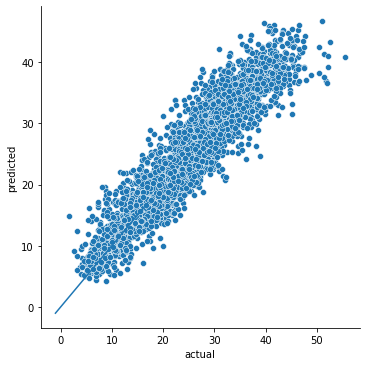

In [24]:
predX_3 = linear_models[2].predict(X_3)
pred3 = pd.DataFrame({'actual':Y,'predicted':predX_3})
pred3['residual'] = pred3.actual - pred3.predicted
print(pred3.head(5))

sns.relplot(x=pred3.actual, y=pred3.predicted)
import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100))

print('R squared =', round(np.corrcoef(pred3.actual, y=pred3.predicted)[0,1]**2,3))

# X_4

      actual  predicted  residual
0  16.773757  17.564560 -0.790803
1  21.496661  24.333113 -2.836452
2  10.931425  15.357811 -4.426387
3  23.119257  24.753795 -1.634538
4  13.652252  12.600307  1.051945
R squared = 0.833


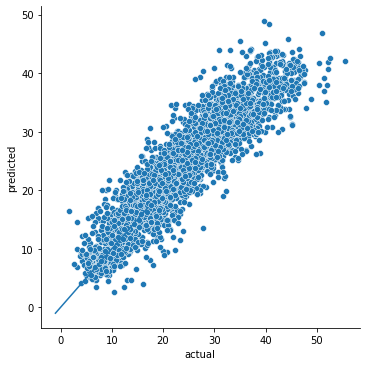

In [25]:
predX_4 = linear_models[3].predict(X_4)
pred4 = pd.DataFrame({'actual':Y,'predicted':predX_4})
pred4['residual'] = pred4.actual - pred4.predicted
print(pred4.head(5))

sns.relplot(x=pred4.actual, y=pred4.predicted)
import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100))

print('R squared =', round(np.corrcoef(pred4.actual, y=pred4.predicted)[0,1]**2,3))

# X_5

      actual  predicted  residual
0  16.773757  17.881663 -1.107907
1  21.496661  25.418125 -3.921464
2  10.931425  13.913743 -2.982318
3  23.119257  25.001317 -1.882060
4  13.652252  11.294005  2.358247
R squared = 0.824


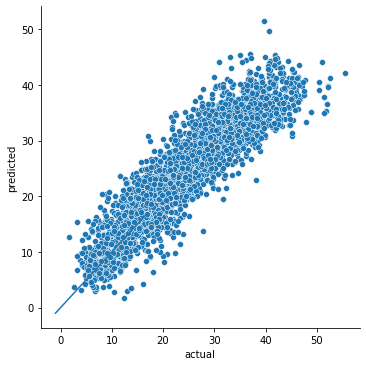

In [26]:
predX_5 = linear_models[4].predict(X_5)
pred5 = pd.DataFrame({'actual':Y,'predicted':predX_5})
pred5['residual'] = pred5.actual - pred5.predicted
print(pred5.head(5))

sns.relplot(x=pred5.actual, y=pred5.predicted)
import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100))

print('R squared =', round(np.corrcoef(pred5.actual, y=pred5.predicted)[0,1]**2,3))

# X_6

      actual  predicted  residual
0  16.773757  16.244024  0.529732
1  21.496661  23.499168 -2.002507
2  10.931425  13.085330 -2.153905
3  23.119257  22.040930  1.078327
4  13.652252  14.311249 -0.658997
R squared = 0.824


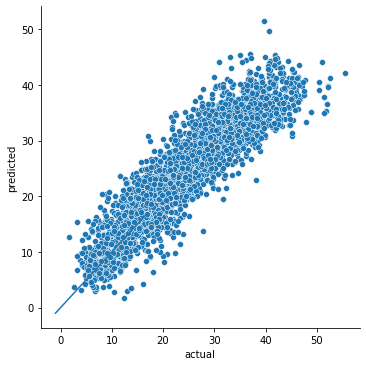

In [27]:
predX_6 = linear_models[5].predict(X_6)
pred6 = pd.DataFrame({'actual':Y,'predicted':predX_6})
pred6['residual'] = pred6.actual - pred6.predicted
print(pred1.head(5))

sns.relplot(x=pred6.actual, y=pred6.predicted)
import matplotlib.pyplot as plt
plt.plot(np.linspace(-1, 17, 100),np.linspace(-1, 17, 100))

print('R squared =', round(np.corrcoef(pred6.actual, y=pred6.predicted)[0,1]**2,3))